## **Image Classification**


1. MNIST 데이터셋을 제외한 다른 공공 데이터셋 선택
2. 해당 데이터셋에 대하여 MLP와 CNN으로 Image Classification 수행
3. ~ipynb 코드 제출 (코드와 실행내용 모두 있어야 함)


&#9989; 해당 파일은 MLP 으로 Image Classification 수행한 내용입니다.

In [7]:
import torch
import random
import os
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# parameters

learning_rate = 0.001
epochs = 100
batch_size = 100
# drop_out = 0.3 아래에 숫자로 적용

### 1. 데이터셋 선택

- Fashion-MNIST    
Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

- (Label	Description)   
0	T-shirt/top    
1	Trouser    
2	Pullover    
3	Dress    
4	Coat     
5	Sandal     
6	Shirt      
7	Sneaker     
8	Bag     
9	Ankle boot      

In [21]:
# torchvision 데이터셋의 출력(output)은 [0, 1] 범위를 갖는 PILImage 이미지입니다. 이를 [-1, 1]의 범위로 정규화된 Tensor로 변환하는 코드
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# -> 수업시간에 배운 transforms.ToTensor()으로 이용

trainset = datasets.FashionMNIST(root='~/.pytorch/F_MNIST_data/', train=True,
                                        download=True, transform=transforms.ToTensor())
trainloader = DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', train=False,
                                       download=True, transform=transforms.ToTensor())

testloader = DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

100%|██████████| 26421880/26421880 [00:01<00:00, 16050697.23it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 283533.28it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5031187.87it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5553569.19it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



In [22]:
# 분류 
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress',
           'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')


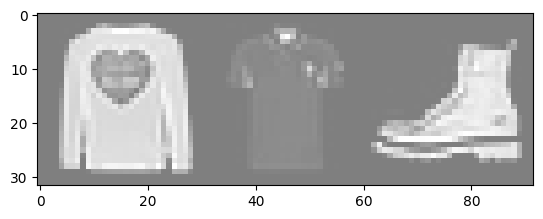

Pullover T-shirt/top Ankle boot


In [23]:
# 데이터 확인
# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(make_grid(images[:3]))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(3)))

### 2. 신경망 구성, MLP 수행

In [25]:
# Mnist 이미지크기:  28x28 

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear( 28*28,512,bias=True)
    self.dropout1 = nn.Dropout(0.3)
    self.fc2 = nn.Linear(512,512,bias=True)
    self.dropout2 = nn.Dropout(0.3)
    self.fc3 = nn.Linear(512,256,bias=True)
    self.dropout3 = nn.Dropout(0.3)                   #dropout 과적합 방지
    self.fc4 = nn.Linear(256,10,bias=True)

  def forward(self, x):
    x = x.view(-1, 28*28).to(device)
    x = self.fc1(x)
    x = nn.functional.relu(x)
    x = self.dropout1(x)
    x = self.fc2(x)
    x = nn.functional.relu(x)
    x = self.dropout2(x)
    x = self.fc3(x)
    x = nn.functional.relu(x)
    x = self.dropout3(x)
    x = self.fc4(x)   # cross entropy loss 이용할거라 마지막에 sofrmax 함수 넣지않음.
    return x

In [26]:
# 모델
model = Net().to(device)

In [27]:
# cost& loss 명시 
criterion = nn.CrossEntropyLoss().to(device)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)  #gradient descent : adam

### 3. 학습

In [28]:
total_batch = len(trainloader)
model.train()

for epoch in range(epochs):
  avg_cost = 0
  for i, data in enumerate(trainloader):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    cost = criterion(outputs, labels)
    cost.backward()
    optimizer.step()

    avg_cost += cost / total_batch
  print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.8f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 0.58037567
Epoch: 0002 cost = 0.41467163
Epoch: 0003 cost = 0.38145941
Epoch: 0004 cost = 0.35928962
Epoch: 0005 cost = 0.34563357
Epoch: 0006 cost = 0.33174083
Epoch: 0007 cost = 0.32035345
Epoch: 0008 cost = 0.31333783
Epoch: 0009 cost = 0.30558860
Epoch: 0010 cost = 0.30073392
Epoch: 0011 cost = 0.29428479
Epoch: 0012 cost = 0.28660515
Epoch: 0013 cost = 0.28052604
Epoch: 0014 cost = 0.27789512
Epoch: 0015 cost = 0.27228084
Epoch: 0016 cost = 0.27095404
Epoch: 0017 cost = 0.26476443
Epoch: 0018 cost = 0.26484391
Epoch: 0019 cost = 0.25593019
Epoch: 0020 cost = 0.25251028
Epoch: 0021 cost = 0.24971889
Epoch: 0022 cost = 0.24787065
Epoch: 0023 cost = 0.24675316
Epoch: 0024 cost = 0.24337505
Epoch: 0025 cost = 0.23877177
Epoch: 0026 cost = 0.23711550
Epoch: 0027 cost = 0.23451447
Epoch: 0028 cost = 0.23201220
Epoch: 0029 cost = 0.23065841
Epoch: 0030 cost = 0.22886902
Epoch: 0031 cost = 0.22961216
Epoch: 0032 cost = 0.22293146
Epoch: 0033 cost = 0.22223474
Epoch: 003

### 4. 테스트

In [31]:
with torch.no_grad():
    model.eval()    
    # Test the model using test sets
    X_test = testset.test_data.view(-1, 28*28).float().to(device)
    Y_test = testset.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())
    
    # 테스트 데이터 랜덤 샘플링하여 결과 예측
    r = random.randint(0, len(testset) - 1)
    X_single_data = testset.test_data[r:r + 1].view(-1, 28*28).float().to(device)
    Y_single_data = testset.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = model(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

Accuracy: 0.8770999908447266
Label:  4
Prediction:  4


In [32]:
# 모델 테스트, 정확도 체크
correct = 0
total = 0

with torch.no_grad():
  model.eval()  
  for data in testloader:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy : {100 * correct // total} %')


Accuracy : 90 %
